C помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [4]:
import pandas as pd
import pandahouse as ph
from datetime import date

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(
    font_scale=2, 
    style     ="whitegrid", 
    rc        = {'figure.figsize': (12, 8)}
)

In [9]:
import getpass

In [13]:
pw = getpass.getpass()

········


In [18]:
# Загружаю данные
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':pw
                     }

### Задача 1

ля начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [19]:
q1 = """
SELECT 
    count(*)
FROM 
    ldn_listings
"""

int(ph.execute(q1, connection_default)) # выгружать таблицу в питон - звучит ресурсозатратно.
                                        # т.к. данная функция выводит информацию в байтах - применил int()

85207

#### Получилось проверить подключение к таблице, питон вернул нужное количество строк, теперь можно спокойно работать

### Задача 2

Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [20]:
# создаем запрос, db автоматически заменится на значение из database
q2 = """
SELECT
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_
FROM 
    ldn_listings
ORDER BY 
    id 
LIMIT 1000
"""
# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q2, connection=connection_default)
q_test.head()

,id,room_type,price_
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0


In [21]:
# делаю функцию, которая возвращает 75 процентиль
def q75(x):
    return x.quantile(0.75)

In [22]:
# группирую с аггрегацией по функции
price_quantile = q_test.query("room_type == 'Private room'") \
    .groupby('room_type', as_index=False) \
    .agg({'price_': [q75]})
price_quantile

,room_type,price_
,,q75
0,Private room,70.0


#### В данном задании получилось использовать приемущества от обоих инструментов

### Задача 3

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [23]:
q3 = """
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating
    FROM
        default.ldn_listings
    WHERE
        review_scores_rating is not null
    ORDER BY id
    LIMIT 1000
    """
q_test3 = ph.read_clickhouse(query=q3, connection=connection_default)
q_test3.shape

(1000, 3)

In [24]:
q_test3.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [25]:
# По заданию обрабатываю данные, группирую по типу жилья и аггрегирую среднюю цену и рейтинг
for_scatterplot = q_test3 \
    .groupby('room_type',as_index=False) \
    .agg({'price': 'mean', 
          'review_scores_rating': 'mean'}) \
    .round()

In [26]:
for_scatterplot.head()

,room_type,price,review_scores_rating
0,Entire home/apt,136.0,94.0
1,Hotel room,134.0,92.0
2,Private room,55.0,95.0
3,Shared room,21.0,90.0


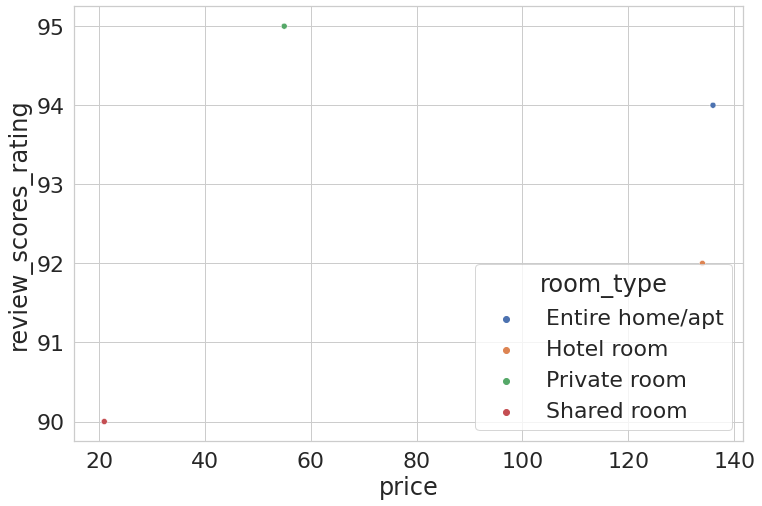

In [27]:
sns.scatterplot(data=for_scatterplot, x='price', y='review_scores_rating', hue='room_type')

#### Получил не так много точек, но по заданию ответ правильный

### Задача 4

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)

host_verifications – какими способами хост подтвердил свой профиль

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [28]:
q4="""
    SELECT
        DISTINCT host_id,
        host_verifications
    FROM
        default.ldn_listings
    WHERE
        experiences_offered != 'none'
    """
q_test4 = ph.read_clickhouse(query=q4, connection=connection_default)
q_test4.shape

(1361, 2)

In [29]:
q_test4.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [30]:
# Получил интересную проблему. Проверил тип данных
q_test4.dtypes

host_id               uint32
host_verifications    object
dtype: object

In [31]:
# Привел данные в колонке в нужный тип (убираю ненужные знаки с помощью strip; потом разбиваю значения по запятой split)
# Для всей колонки в дф использовал фуекцию apply
q_test4 = q_test4.host_verifications.apply(lambda x: x.strip('[]').split(', '))

In [32]:
q_test4

0       ['email', 'phone', 'facebook', 'reviews', 'off...
1       ['email', 'phone', 'reviews', 'jumio', 'govern...
2       ['email', 'phone', 'jumio', 'selfie', 'governm...
3       ['email', 'phone', 'manual_offline', 'jumio', ...
4       ['email', 'phone', 'reviews', 'offline_governm...
                              ...                        
1356    ['email', 'phone', 'reviews', 'jumio', 'govern...
1357    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1358    ['email', 'phone', 'reviews', 'jumio', 'govern...
1359    ['email', 'phone', 'google', 'reviews', 'jumio...
1360    ['email', 'phone', 'reviews', 'manual_offline'...
Name: host_verifications, Length: 1361, dtype: object

In [33]:
# перевел из одной строки по нескольким значениям для каждого host_id.
# разбиваю с помощью explode строки
q_test4 = q_test4.explode('host_verifications') 

In [34]:
q_test4.value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

#### 34 хозяина подтвердили профиль с помощью аккаунта Google

### Задача 5

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True)

In [35]:
q5 ="""
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(*) AS experiences_count
FROM 
    ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed, experiences_offered
ORDER BY 
    experiences_count DESC

LIMIT 100
    """
q5 = ph.read_clickhouse(query=q5, connection=connection_default)
q5.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [36]:
# Преобразовываю данные
data_pivot = q5.pivot(index='neighbourhood_cleansed',
                 columns='experiences_offered',
                 values='experiences_count'
                )

In [37]:
data_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


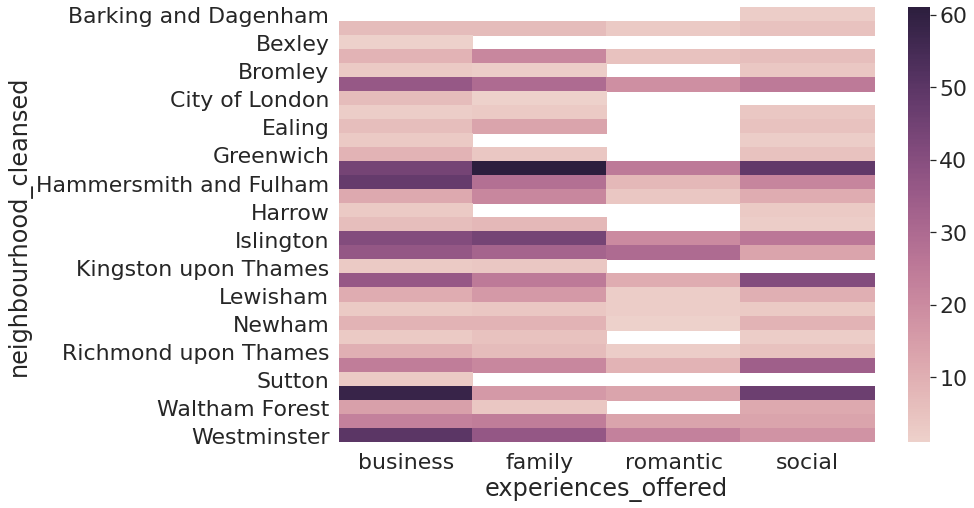

In [38]:
sns.heatmap(data = data_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

### Задача 6

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

price – цена за ночь

experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [39]:
q6 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM 
    ldn_listings
WHERE 
    experiences_offered != 'none'
"""
q6 = ph.read_clickhouse(query=q6, connection=connection_default)
q6.shape

(1548, 2)

In [40]:
q6.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


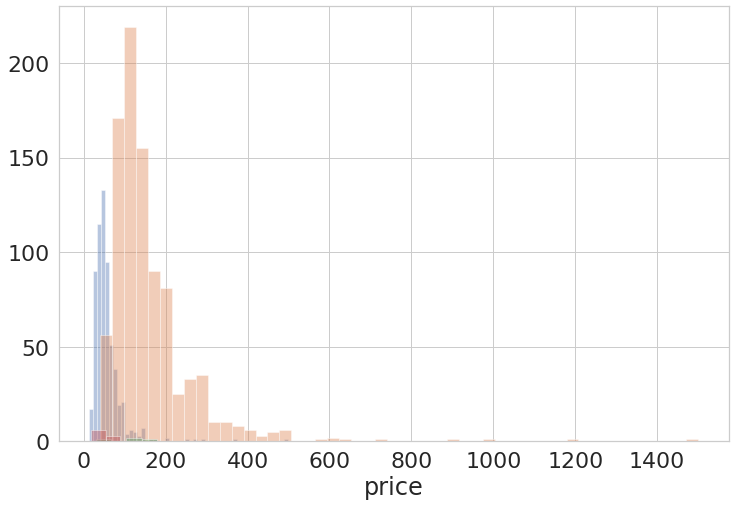

In [41]:
# Применил функцию для построения сразу нескольких типов комнат в одном графике
for room in q6.room_type.unique():
    sns.distplot(q6[q6.room_type == room].price, kde=False)

In [42]:
# Теперь тоже самое, только с логорифм. значениями
for room in q6.room_type.unique():
    sns.distplot(np.log(q6[q6.room_type == room].price), kde=False)

NameError: name 'np' is not defined

#### С помощью питона удалось визуализировать и построить распределение цен в зависимости от разного типа жилья

### Задача 7

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

price – цена за ночь

first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [43]:
q7 ="""
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM 
    ldn_listings
WHERE  
    first_review > '2010-01-01'
LIMIT 1000
"""
q7 = ph.read_clickhouse(query=q7, connection=connection_default)

In [44]:
q7

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [45]:
# перевел колонку в дата формат
q7['first_review'] = pd.to_datetime(q7['first_review'])

In [46]:
#отделил год от дат
q7.loc[:, 'first_review'] = q7.loc[:, 'first_review'].dt.year

In [47]:
q7.head()

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [48]:
for_plot = q7.groupby(['room_type', 'first_review']) \
            .agg({'price': 'mean'}) \
            .round() \
            .reset_index()

In [49]:
for_plot

,room_type,first_review,price
0,Entire home/apt,2010,104.0
1,Entire home/apt,2011,129.0
2,Entire home/apt,2012,135.0
3,Entire home/apt,2013,138.0
4,Entire home/apt,2014,155.0
5,Entire home/apt,2015,159.0
6,Entire home/apt,2016,100.0
7,Entire home/apt,2017,112.0
8,Entire home/apt,2018,125.0
9,Entire home/apt,2019,302.0


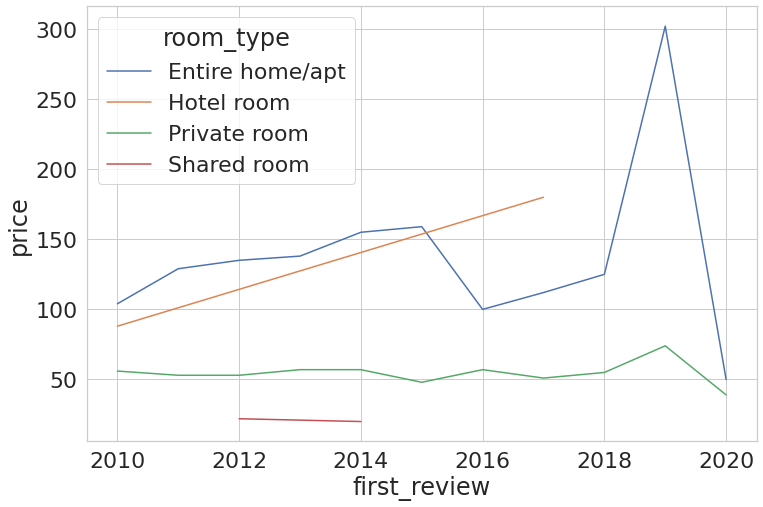

In [50]:
sns.lineplot(x='first_review',y='price',hue='room_type',data=for_plot)